In [32]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

## Function for Creating Dataset

In [33]:
def createData(size):
    dataListX=[]
    dataListY=[]
    for _ in range(size):
        a=random.randint(2,9)
        b=np.random.rand(a)   #creating the random array of size between (2,9)
        zero=np.zeros(a)
        first =random.randint(0,a-1) #creating the zero array of size same as b
        zero[first]=1                #making first index 1
        second=random.randint(0,a-1)
        while(second==first):        #checking that second index must be not same as first
            second=random.randint(0,a-1)

        zero[second]=1               #making the second index1

        lebel=np.zeros(1)

        for i in range(zero.shape[0]):    # summing for output
            if(zero[i]==1.):
                lebel += b[i]

        final=np.stack((b,zero),0)   #appending the both array in same array
        dataListX.append(final.tolist()) 
        dataListY.append(lebel.tolist())
        
    return dataListX,dataListY      #returining the X and Y


In [34]:
# dataset for training
X,Y=createData(5500)
Y=torch.tensor(Y)


In [35]:
#dataset for testing
TestX,TestY=createData(1000)
TestY=torch.tensor(TestY)

# Elmon

In [36]:
class Elmon():
    def __init__(self):
        self.U=torch.rand(3,2,requires_grad=True)
        self.H=torch.zeros(3,1)
        self.W=torch.rand(3,3,requires_grad=True)
        self.bh=torch.rand(3,1,requires_grad=True)
        self.V=torch.rand(1,3,requires_grad=True)
        self.by=torch.rand(1,1,requires_grad=True)
        self.MSE=torch.nn.MSELoss()
        self.optimiser=torch.optim.SGD([self.U,self.W,self.bh,self.V,self.by],lr=0.01)

    def ForwardPass(self,a):
        temp_H = self.H
        for i in range(a.shape[1]):
            x=a[:,i].reshape(2,-1)
            temp_H=torch.tanh(torch.matmul(self.U,x)+torch.matmul(self.W,temp_H)+self.bh)
        firstTerm=torch.matmul(self.V,temp_H)
        y=firstTerm+self.by
        return y
    
    def Train(self,X,Y,epoch):
        ElmonLoss=[]
        for j in range(epoch):
            total_ls =0 
            for i in range(len(X)):
                a=torch.tensor(X[i])
                ypre=self.ForwardPass(a)
                ypre=ypre.reshape(-1)
                self.optimiser.zero_grad()
                los=self.MSE(ypre,Y[i])

                total_ls = total_ls + los.detach().item()
            
                los.backward()
                self.optimiser.step()

            ElmonLoss.append(total_ls/len(X))
            if j%5==0:
                print(f' loss at epoch {j} is {total_ls/len(X)}')

        return ElmonLoss
    
    def Test(self,X,Y):
        total_ls =0 
        for i in range(len(X)):
            a=torch.tensor(X[i])
            ypre=self.ForwardPass(a)
            ypre=ypre.reshape(-1)
            los=self.MSE(ypre,Y[i])
            total_ls = total_ls + los.detach().item()
    
        return total_ls/len(X)

In [37]:
elmon=Elmon()

In [38]:
elmonLoss=elmon.Train(X,Y,25)

 loss at epoch 0 is 0.15179476196568983
 loss at epoch 5 is 0.031710974282004596
 loss at epoch 10 is 0.008334402556968457
 loss at epoch 15 is 0.007749570245209208
 loss at epoch 20 is 0.007563415642729862


In [39]:
# testing over 1000 dataset and MSE loss is storing into  ElmonTest
ElmonTest=elmon.Test(TestX,TestY)
ElmonTest

0.005891017763157624

# LSTM

In [40]:
class LSTM():
    def __init__(self):
       self.H=torch.zeros(5,1)
       self.W_f=torch.rand(5,7,requires_grad=True)
       self.b_f=torch.rand(5,1,requires_grad=True)
       self.W_i=torch.rand(5,7,requires_grad=True)
       self.b_i=torch.rand(5,1,requires_grad=True)
       self.W_c=torch.rand(5,7,requires_grad=True)
       self.b_c=torch.rand(5,1,requires_grad=True)
       self.W_o=torch.rand(5,7,requires_grad=True)
       self.b_o=torch.rand(5,1,requires_grad=True)
       self.C=torch.zeros(5,1)
       self.W_fi=torch.rand(1,5,requires_grad=True)
       self.W_ci=torch.rand(1,1,requires_grad=True)
       self.MSE=torch.nn.MSELoss()
       self.optimiser=torch.optim.SGD([self.W_f,self.b_f,self.W_i,self.b_i,self.W_c,self.b_c,self.W_o,self.b_o,self.W_fi,self.W_ci],lr=0.05)

    def ForwarPass(self,a):
        tempH=self.H
        tempC=self.C
        for i in range(a.shape[1]):
            x=a[:,i].reshape(2,-1)
            a_=torch.cat((tempH,x),0)
            first=torch.matmul(self.W_f,a_)
            forgetGet=torch.sigmoid(first+self.b_f)

            i=torch.cat((tempH,x),0)
            first=torch.matmul(self.W_i,i)
            I=torch.sigmoid(first+self.b_i)

            c=torch.cat((tempH,x),0)
            first=torch.matmul(self.W_c,c)
            C_=torch.sigmoid(first+self.b_c)

            tempC=torch.mul(forgetGet,tempC)+torch.mul(I,C_)

            o=torch.cat((tempH,x),0)
            first=torch.matmul(self.W_o,o)
            ot=torch.sigmoid(first+self.b_o)
            
            tempH=torch.mul(ot,torch.tanh(tempC))

        y=torch.relu(torch.matmul(self.W_fi,tempH)+self.W_ci)
        return y
    
    def Train(self,X,Y,epoch):
        LSTMloss=[]
        for j in range(epoch):
            total_ls =0 
            for i in range(len(X)):
                a=torch.tensor(X[i])
                ypre=self.ForwarPass(a)
                ypre=ypre.reshape(-1)
            
                los=self.MSE(ypre,Y[i])
                self.optimiser.zero_grad()
                total_ls = total_ls + los.detach().item()
            
                los.backward()
                
                self.optimiser.step()
            
            LSTMloss.append(total_ls/len(X))
            if j%5==0:
                print(f' loss at epoch {j} is {total_ls/len(X)}')
        return LSTMloss
    
    def Test(self,X,Y):
        total_ls =0 
        for i in range(len(X)):
            a=torch.tensor(X[i])
            ypre=self.ForwarPass(a)
            ypre=ypre.reshape(-1)
            los=self.MSE(ypre,Y[i])
            total_ls = total_ls + los.detach().item()

        return total_ls/len(X)

In [41]:
lstm=LSTM()

In [42]:
lstmLoss=lstm.Train(X,Y,25)

 loss at epoch 0 is 0.19605936562880028
 loss at epoch 5 is 0.0025380806018121243
 loss at epoch 10 is 0.0010468738017585396
 loss at epoch 15 is 0.0006622109732421548
 loss at epoch 20 is 0.000491665722004142


In [43]:
lstmTest=lstm.Test(TestX,TestY)
lstmTest

0.0003380870940776326

# GRU

In [44]:
class GRU():
    def __init__(self):
        self.H=torch.zeros(5,1)
        self.W_z=torch.rand(5,7,requires_grad=True)
        self.b_z=torch.rand(5,1,requires_grad=True)
        self.W_r=torch.rand(5,7,requires_grad=True)
        self.b_r=torch.rand(5,1,requires_grad=True)
        self.W_h=torch.rand(5,7,requires_grad=True)
        self.b_h=torch.rand(5,1,requires_grad=True)
        self.W_fi=torch.rand(1,5,requires_grad=True)
        self.W_ci=torch.rand(1,1,requires_grad=True)
        
        self.MSE=torch.nn.MSELoss()
        self.optimiser=torch.optim.SGD([self.W_z,self.b_z,self.W_r,self.b_r,self.W_h,self.b_h,self.W_fi,self.W_ci],lr=0.04)


    def ForwarPass(self,a):
        temp=self.H 
        for i in range(a.shape[1]):
            x=a[:,i].reshape(2,-1)
            a_=torch.cat((temp,x),0)
            z=torch.sigmoid(torch.matmul(self.W_z,a_)+self.b_z)

            r=torch.sigmoid(torch.matmul(self.W_r,a_)+self.b_r)

            m=torch.mul(r,temp)
            m_=torch.cat((m,x),0)
            h=torch.tanh(torch.matmul(self.W_h,m_)+self.b_h) 

            temp=torch.mul((1-z),temp)+torch.mul(z,h)
        y=torch.matmul(self.W_fi,temp)+self.W_ci 
        return y
    
    def Train(self,X,Y,epoch):
        GruLoss=[]
        for j in range(epoch):
            total_ls =0 
            for i in range(len(X)):
                a=torch.tensor(X[i])
                ypre=self.ForwarPass(a)
                ypre=ypre.reshape(-1)
                los=self.MSE(ypre,Y[i])
                self.optimiser.zero_grad()
                total_ls = total_ls + los.detach().item()
            
                los.backward()
                
                self.optimiser.step()
            
            GruLoss.append(total_ls/len(X))
            if j%5==0:
                print(f' loss at epoch {j} is {total_ls/len(X)}')
        return GruLoss
    
    def Test(self,X,Y):
        total_ls =0 
        for i in range(len(X)):
            a=torch.tensor(X[i])
            ypre=self.ForwarPass(a)
            ypre=ypre.reshape(-1)
            los=self.MSE(ypre,Y[i])
            total_ls = total_ls + los.detach().item()

        return total_ls/len(X)

In [45]:
gru=GRU()

In [46]:
GruLoss=gru.Train(X,Y,25)

 loss at epoch 0 is 0.10533176189822725
 loss at epoch 5 is 0.0012426743449648757
 loss at epoch 10 is 0.0007293666142842713
 loss at epoch 15 is 0.0005389460199393094
 loss at epoch 20 is 0.00044237369112974596


In [47]:
# testing the Gru over 1000 dataset
gruTest=gru.Test(TestX,TestY)
gruTest

0.00017749198524513333

In [48]:
Y=Y.reshape(-1)
BaseLine=torch.ones(len(Y))
MSE=torch.nn.MSELoss()
BaseLineLoss=MSE(Y,BaseLine)
BaseLineLoss

tensor(0.1646)

Text(0.5, 1.0, 'Loss comparisation during Training')

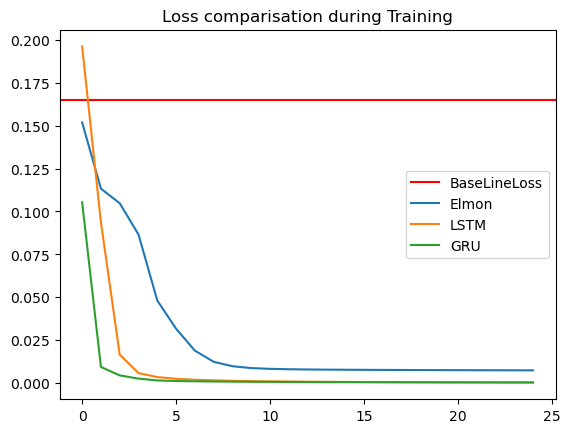

In [49]:
plt.axhline(y=[BaseLineLoss.item()],color='r', linestyle='-')
plt.plot(elmonLoss)
plt.plot(lstmLoss)
plt.plot(GruLoss)
plt.legend(['BaseLineLoss','Elmon','LSTM','GRU'])
plt.title("Loss comparisation during Training")

Text(0.5, 1.0, 'Performance Test With Baseline Loss')

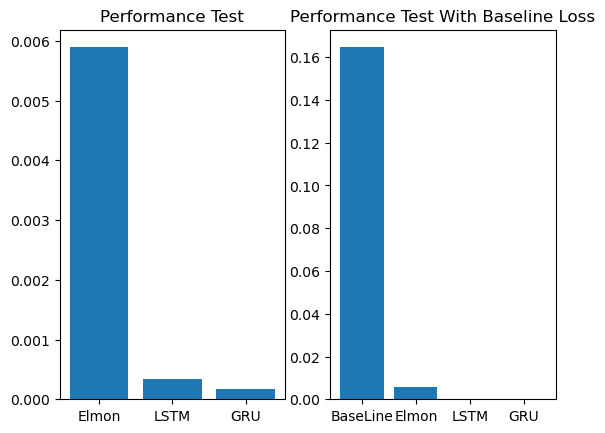

In [50]:
plt.subplot(1,2,1)
plt.bar(['Elmon','LSTM','GRU'],[ElmonTest,lstmTest,gruTest])
plt.title('Performance Test')

plt.subplot(1,2,2)
plt.bar(['BaseLine','Elmon','LSTM','GRU'],[BaseLineLoss,ElmonTest,lstmTest,gruTest])
plt.title('Performance Test With Baseline Loss')